# Deep Learning (RNN model)

## Imports

In [2]:
# DATA MANIPULATION, Visualization, and stats
import pandas as pd
from glob import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

# Deep Learning
import tensorflow as tf

In [3]:
# Your current working directory should be ./mattwagon/oil_production_prediction/notebooks
os.getcwd()

'/home/galinasamotorova/code/GalinaSa/Final-Project'

## Import the data

In [4]:
# This filepath should work for all of us
# I have added 'raw_data' to .gitignore so it should never be pushed to the repo
path = 'data'
file_names = os.listdir(path)
csv_files = [f for f in file_names if f.endswith('.csv')]

csv_files.sort()

df = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(path, file)
    df_aux = pd.read_csv(file_path)
    df = pd.concat([df, df_aux], ignore_index=True)

In [5]:
df.head()

,Date,Calculated Drawdown_At Gauge,Calculated Drawdown_At Bottom Node,Reservoir Pressure,z Well Identifier,z TMore PS Identifier,z TMore Identifier,z Tag Identifier 2,z Tag Identifier,z PI-AF Database,...,Annulus Master Valve Status,Annulus Master Valve Opening Frequency,Pseudo Cv,GL GOR,GL Qgas,GL Qliq,GL Qoil,GL Qwat,GL Ramp-up Speed,GL WCT
0,2007-02-01 00:00:00+01:00,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
1,2007-02-02 00:00:00+01:00,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
2,2007-02-03 00:00:00+01:00,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
3,2007-02-04 00:00:00+01:00,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08
4,2007-02-05 00:00:00+01:00,NaN,NaN,186.34,30221,NaN,NaN,1,3022,NaN,...,NaN,NaN,NaN,52.5,90.0,32300.0,10960.0,21360.0,NaN,66.08


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.tz_convert(None)
df['Date'] = pd.to_datetime(df['Date'].apply(lambda x: x + pd.DateOffset(hours=1)))

## Data cleaning

### Drop features with all NaN and >30% NaN values

In [7]:
features_nan_drop = []

for feature, value in dict(df.isnull().sum().sort_values(ascending=False)).items():
    if value/len(df) > 0.3:
        features_nan_drop.append(feature)
        
df.drop(columns=features_nan_drop, inplace=True)
df.shape

(5813, 65)

### Drop features with std = 0

In [8]:
features_null_std = []

for feature in df.drop(columns='Date').columns:
    if df[feature].std() < 0.0000001:
        features_null_std.append(feature)
        
df.drop(columns=features_null_std, inplace=True)

df.shape

(5813, 41)

### Drop corrected, 'choke' and correlated features, and from 'remove' dict

In [9]:
corrected_features_drop = ['Qwat MPFM corrected', 'Qoil MPFM corrected', 'Qliq MPFM corrected', 'Qgas MPFM corrected']
df.drop(columns=corrected_features_drop, inplace=True)

In [10]:
choke_features_drop = ['Choke Opening Calc1', 'Choke Opening Calc2', 'Choke Measured', 'Choke Calculated', 'Choke CCR']
df.drop(columns=choke_features_drop, inplace = True)

In [11]:
features_corr_drop = ['Qwat PC', 'Qgas PC', 'Qoil PC', 'Tubing dP','MPFM P']
df.drop(columns=features_corr_drop, inplace = True)

In [12]:
remove = {"Sand Rate", "MPFM NTotal Count Rate", "MPFM N81 Count Rate", "MPFM N356 Count Rate", "MPFM N32 Count Rate", "MPFM GOR", "Downhole Gauge T", "Downhole Gauge P", "Service Line P", "Manifold T", "Jumper T"}
df.drop(columns=remove, inplace=True)

In [13]:
df.shape

(5813, 16)

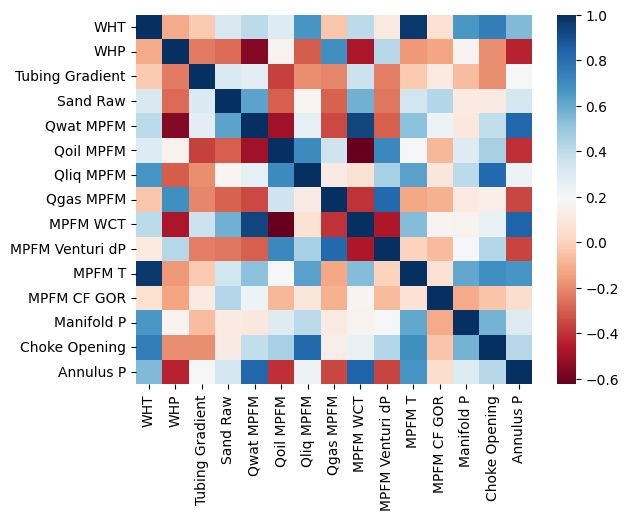

In [14]:
# Pairwise correlation
sns.heatmap(df.corr(), cmap='RdBu')
plt.show()

### Back to basics: reduce noise / manually clean the data

In [15]:
# starting the first model with 2 features only + our Target 'Qoil MPFM'

df_clean = df[["Qoil MPFM","MPFM WCT", "Qliq MPFM"]].copy()
df_clean

,Qoil MPFM,MPFM WCT,Qliq MPFM
0,NaN,0.000000,NaN
1,NaN,0.000000,NaN
2,NaN,0.000000,NaN
3,NaN,0.000000,NaN
4,NaN,0.000000,NaN
...,...,...,...
5808,10925.670806,66.457010,32572.143637
5809,11142.564473,65.386773,32191.637342
5810,11140.120568,65.647569,32428.914925
5811,11400.139595,64.967486,32541.597131


In [16]:
df_clean['Qoil MPFM'].mask(df_clean['Qoil MPFM'].between(-1, 4000), inplace=True)
df_clean['MPFM WCT'].mask(df_clean['MPFM WCT'].between(-1, 1), inplace=True)
df_clean['Qliq MPFM'].mask(df_clean['Qliq MPFM'].between(-1, 10000), inplace=True)


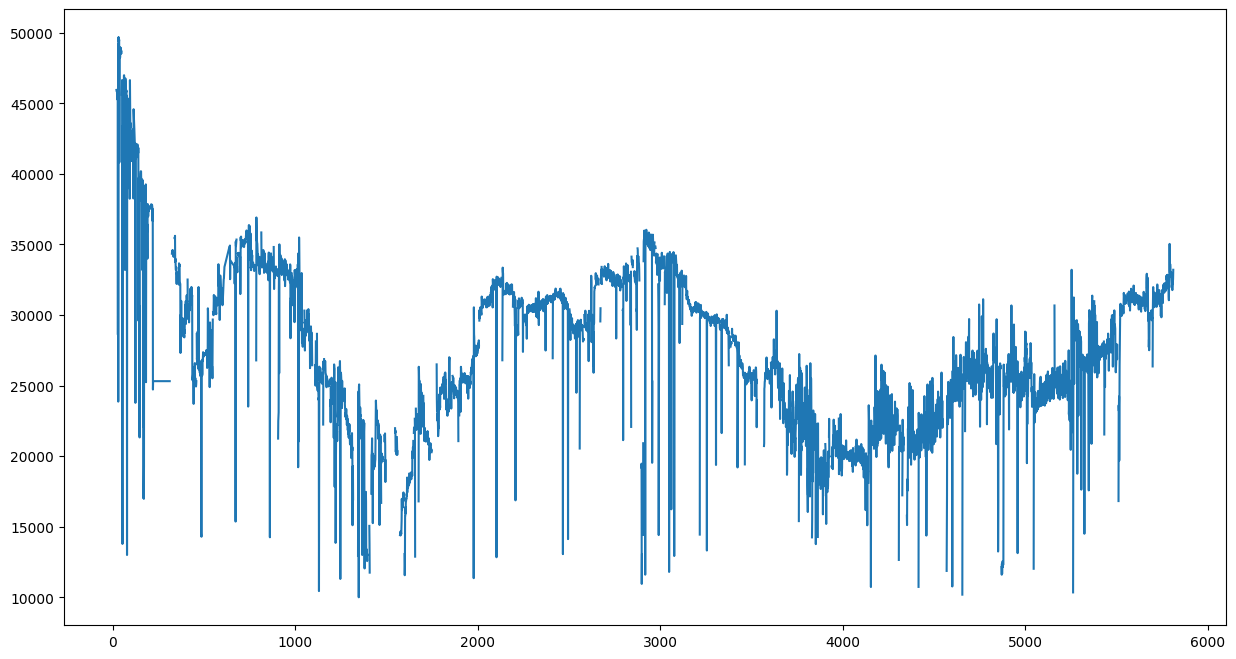

In [17]:
plt.figure(figsize=(15, 8))
plt.plot(df_clean['Qliq MPFM'])
plt.show();

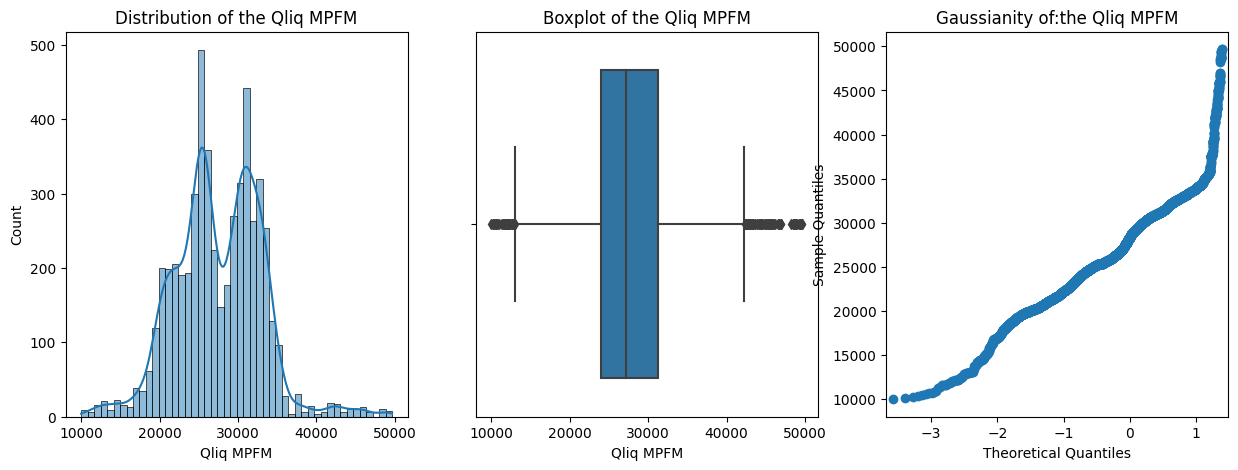

In [18]:
variable = 'Qliq MPFM'

fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].set_title(f"Distribution of the {variable}")
sns.histplot(data = df_clean, x = f"{variable}", kde=True, ax = ax[0])

ax[1].set_title(f"Boxplot of the {variable}")
sns.boxplot(data = df_clean, x = f"{variable}", ax=ax[1])

ax[2].set_title(f"Gaussianity of:the {variable}")
sm.qqplot(df_clean[f"{variable}"],line='s',ax=ax[2]);


In [19]:
for feature in df_clean.columns:
    df_clean[feature].replace(np.nan, df_clean[feature].median(), inplace=True)

In [20]:
df_clean.isnull().sum()

Qoil MPFM    0
MPFM WCT     0
Qliq MPFM    0
dtype: int64

In [21]:
df_clean.describe()

,Qoil MPFM,MPFM WCT,Qliq MPFM
count,5813.000000,5813.000000,5813.000000
mean,16395.897186,42.579947,27483.372157
std,8104.099787,21.743151,5318.329266
min,4062.757558,1.002506,10004.995528
25%,10175.329857,23.221134,24397.505978
50%,14876.383336,52.109728,27115.061833
75%,18393.306228,59.913923,31090.037056
max,49223.595339,91.660984,49676.388581


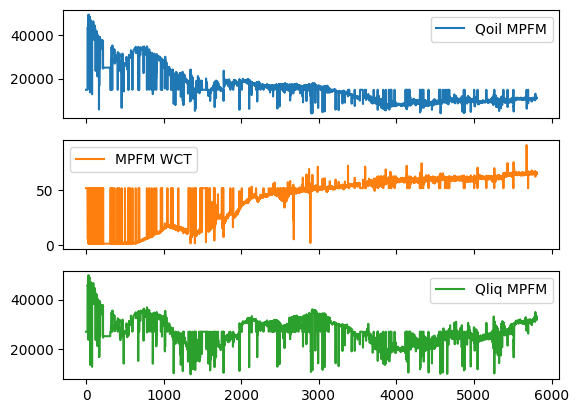

In [23]:
TARGET = 'Qoil MPFM'
N_TARGETS = 1
N_FEATURES = df_clean.shape[1] - 1

plot_cols = [TARGET,"MPFM WCT", "Qliq MPFM"]
plot_features = df_clean[plot_cols]
plot_features.index = df_clean.index
plot_features.plot(subplots = True);

In [24]:
FOLD_LENGTH = 365 * 7 # seven years
FOLD_STRIDE = 91 # 3 months
TRAIN_TEST_RATIO = 0.66

In [25]:
def get_folds(
    df_clean: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> list[pd.DataFrame]:
   
    fold_list = []
    
    for i in range(0, len(df_clean), fold_stride):
        if i + fold_length >= len(df_clean):
            break
        fold_list.append(df_clean[i:fold_length])
    
    return fold_list

In [26]:
folds = get_folds(df_clean, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 36 folds.
Each fold has a shape equal to (2555, 3).


In [27]:
fold = folds[0]
fold

,Qoil MPFM,MPFM WCT,Qliq MPFM
0,14876.383336,52.109728,27115.061833
1,14876.383336,52.109728,27115.061833
2,14876.383336,52.109728,27115.061833
3,14876.383336,52.109728,27115.061833
4,14876.383336,52.109728,27115.061833
...,...,...,...
2550,17148.121788,41.696902,29412.025079
2551,17015.530166,41.271305,28973.111534
2552,14876.383336,52.109728,27115.061833
2553,14876.383336,52.109728,27115.061833


In [28]:
INPUT_LENGTH = 14 # two weeks

In [29]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple[pd.DataFrame]:
   
    # TRAIN SET
    # ======================
    last_train_idx = round(train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_idx, :]

    # TEST SET
    # ======================    
    first_test_idx = last_train_idx - input_length
    fold_test = fold.iloc[first_test_idx:, :]

    return (fold_train, fold_test)

In [30]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

In [31]:
print(f'Each fold has a shape equal to {fold.shape}.')
print(f'Each fold_train has a shape equal to {fold_train.shape}.')
print(f'Each fold_test has a shape equal to {fold_test.shape}.')

Each fold has a shape equal to (2555, 3).
Each fold_train has a shape equal to (1686, 3).
Each fold_test has a shape equal to (883, 3).


In [32]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH} days = {int(INPUT_LENGTH/7)} weeks')

N_FEATURES = 2
INPUT_LENGTH = 14 days = 2 weeks


In [33]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')

# Let's only predict 1 value ahead of us
OUTPUT_LENGTH = 1
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 1
OUTPUT_LENGTH = 1


In [34]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int):
    
    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]    
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length][[TARGET]]
    
    return (X_i, y_i)

In [35]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)

In [36]:
X_train_i.shape

(14, 3)

In [37]:
# Advanced check 
# You should not allow some truncated (X_i,y_i) pairs to be generating,
# should you start sampling too close from the end of the fold... !

X_last, y_last = get_Xi_yi(fold_test, input_length=len(fold_test)-1, output_length=OUTPUT_LENGTH)
assert y_last.values == fold_test.iloc[-1,:][TARGET]

In [38]:
SEQUENCE_STRIDE = 1 #temporal stride of 1 day

In [39]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, sequence_stride: int):
   
    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) >= len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][[TARGET]]
        X.append(X_i)
        y.append(y_i)

    return np.array(X), np.array(y)

In [40]:
print("FOLD_LENGTH") 
print(f"= {int(FOLD_LENGTH)} days")
print(f"= {int(FOLD_LENGTH/7)} weeks")

FOLD_LENGTH
= 2555 days
= 365 weeks


In [41]:
X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train.shape)
print(y_train.shape)

(1671, 14, 3)
(1671, 1, 1)


#### DL modeling

Baseline Model

In [42]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras import models
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Normalization

def init_baseline_clean():

    model = models.Sequential()
    model.add(layers.Lambda(lambda x: x[:,-1,1,None]))

    adam = optimizers.Adam(learning_rate=0.02)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model

In [44]:
baseline_model_clean = init_baseline_clean()
baseline_score_clean = baseline_model_clean.evaluate(X_test, y_test)
print(f"- The Baseline MAE on the test set is equal to {baseline_score_clean[1]} barrels")

28/28 [==============================] - 0s 893us/step - loss: 295842784.0000 - mae: 17133.8184
- The Baseline MAE on the test set is equal to 17133.818359375 barrels


LSTM 

In [50]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [45]:
def init_model_clean(X_train, y_train):
    
    # 0 - Normalization
    # ======================    
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    # 1 - RNN architecture
    # ======================    
    model = models.Sequential()
    ## 1.0 - All the rows will be standardized through the already adapted normalization layer
    model.add(normalizer)
    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(256, 
                          activation='tanh', 
                          return_sequences = False,
                          kernel_regularizer=L1L2(l1=0.05, l2=0.05),
                          ))
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    # 2 - Compiler
    # ======================    
    adam = optimizers.Adam(learning_rate=0.02)    
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])
    
    return model

In [46]:
model_clean = init_model_clean(X_train, y_train)
model_clean.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 3)          7         
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, 256)               266240    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 266,504
Trainable params: 266,497
Non-trainable params: 7
_________________________________________________________________


In [47]:
from tensorflow.keras.callbacks import EarlyStopping
from typing import Dict, List, Tuple, Sequence

def fit_model(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:

    es = EarlyStopping(monitor = "val_loss",
                      patience = 5,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 16,
                        epochs = 120,
                        callbacks = [es],
                        verbose = verbose)

    return model, history

In [48]:
model_clean, history_clean = fit_model(model_clean)

Epoch 1/120
74/74 [==============================] - 2s 16ms/step - loss: 924162240.0000 - mae: 29580.3926 - val_loss: 284880736.0000 - val_mae: 16558.7793
Epoch 2/120
74/74 [==============================] - 1s 13ms/step - loss: 910355968.0000 - mae: 29344.5859 - val_loss: 276243552.0000 - val_mae: 16295.8848
Epoch 3/120
74/74 [==============================] - 1s 13ms/step - loss: 894216512.0000 - mae: 29068.2129 - val_loss: 267432256.0000 - val_mae: 16023.2578
Epoch 4/120
74/74 [==============================] - 1s 12ms/step - loss: 878676736.0000 - mae: 28799.8496 - val_loss: 258958144.0000 - val_mae: 15756.6045
Epoch 5/120
74/74 [==============================] - 1s 13ms/step - loss: 863491392.0000 - mae: 28535.1523 - val_loss: 250759808.0000 - val_mae: 15494.2646
Epoch 6/120
74/74 [==============================] - 1s 12ms/step - loss: 848644864.0000 - mae: 28273.8203 - val_loss: 242717632.0000 - val_mae: 15232.5303
Epoch 7/120
74/74 [==============================] - 1s 13ms/ste

74/74 [==============================] - 1s 12ms/step - loss: 336917504.0000 - mae: 17001.3594 - val_loss: 26245272.0000 - val_mae: 4389.5610
Epoch 54/120
74/74 [==============================] - 1s 12ms/step - loss: 329447328.0000 - mae: 16781.5566 - val_loss: 24549526.0000 - val_mae: 4209.6758
Epoch 55/120
74/74 [==============================] - 1s 12ms/step - loss: 322100512.0000 - mae: 16562.9844 - val_loss: 22956936.0000 - val_mae: 4031.1599
Epoch 56/120
74/74 [==============================] - 1s 13ms/step - loss: 314876000.0000 - mae: 16345.1699 - val_loss: 21466530.0000 - val_mae: 3855.9397
Epoch 57/120
74/74 [==============================] - 1s 13ms/step - loss: 307773088.0000 - mae: 16128.1250 - val_loss: 20077346.0000 - val_mae: 3684.6289
Epoch 58/120
74/74 [==============================] - 1s 12ms/step - loss: 313273312.0000 - mae: 16399.2578 - val_loss: 29427816.0000 - val_mae: 4709.1670
Epoch 59/120
74/74 [==============================] - 1s 13ms/step - loss: 34511676

array([<AxesSubplot:title={'center':'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot:title={'center':'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

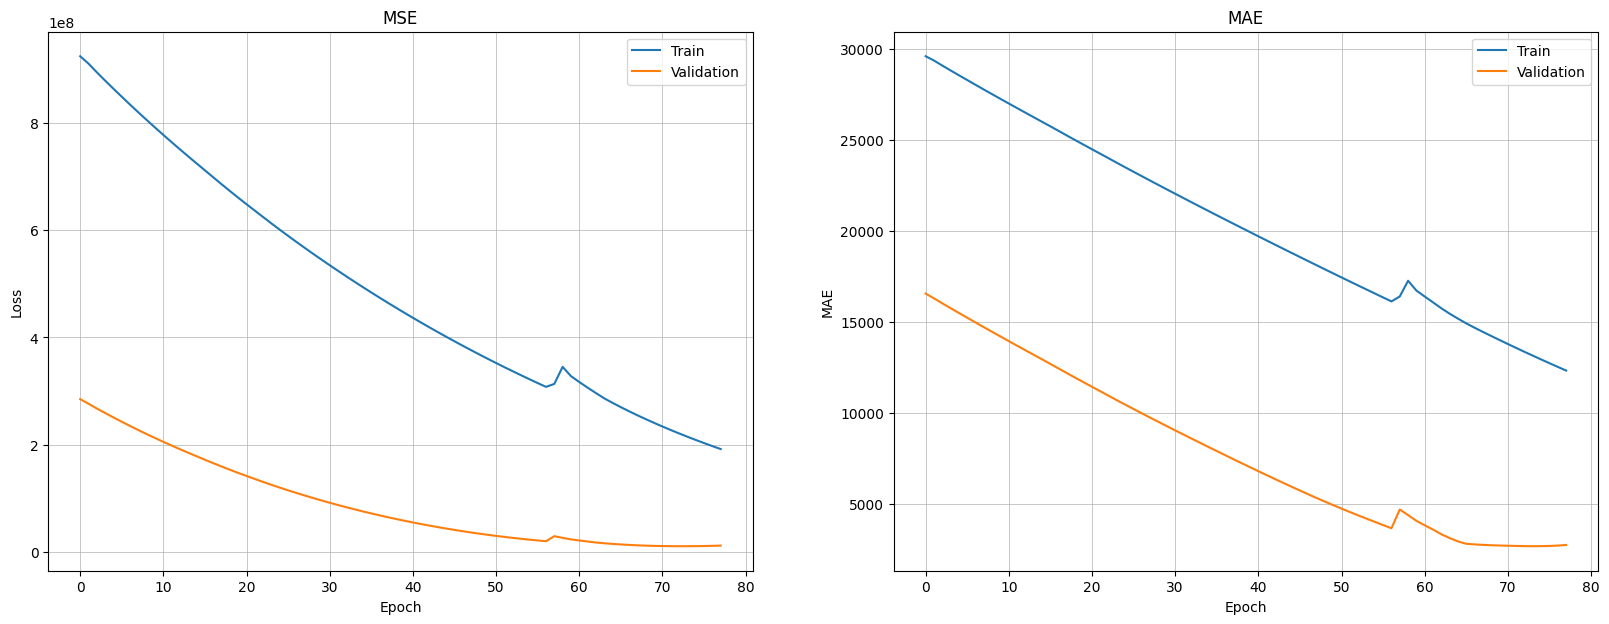

In [51]:
plot_history(history_clean)

In [52]:
res_clean = model_clean.evaluate(X_test, y_test)
print(f"The LSTM MAE on the test set is equal to {res_clean[1]} barrels")

28/28 [==============================] - 0s 5ms/step - loss: 2482424.0000 - mae: 1136.8485
The LSTM MAE on the test set is equal to 1136.8485107421875 barrels


28/28 [==============================] - 0s 5ms/step


<AxesSubplot:>

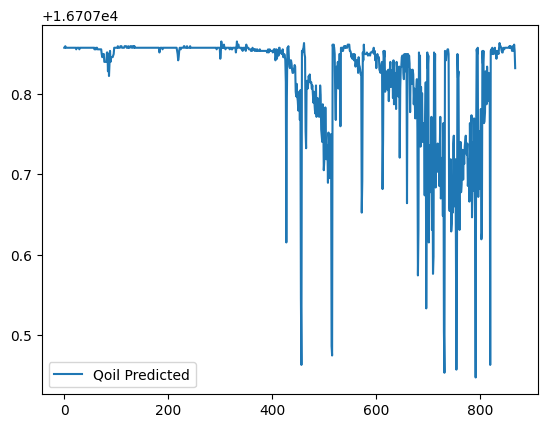

In [53]:
y_pred_clean = model_clean.predict(X_test)
prediction_clean = pd.DataFrame(y_pred_clean, columns =['Qoil Predicted'])
prediction_clean.plot()

In [55]:
features = pd.DataFrame(X_test[:,0],
                 columns=["Qoil MPFM Real","MPFM WCT", "Qliq MPFM"])
oil = features[["Qoil MPFM Real"]].copy()
oil

,Qoil MPFM Real
0,17524.723824
1,17089.759453
2,18200.320675
3,14876.383336
4,11092.600326
...,...
863,16602.875352
864,16756.941549
865,16654.113278
866,16476.113629


<AxesSubplot:>

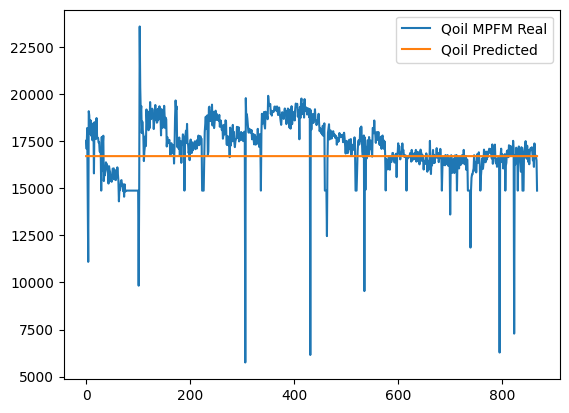

In [58]:
results=pd.concat([oil,prediction_clean],axis=1)
results.plot()